In [ ]:
# importing stuff

import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch import tensor as tt
import gzip
import torch.optim as optim
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
# reading data into 4 tensors

import gzip
f = gzip.open('train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 60000
num_images_test = 10000

f.read(16)
buf = f.read(image_size * image_size * num_images)
data = torch.frombuffer(buf, dtype=torch.uint8).to(torch.float32)
data = data.reshape(num_images, 1, image_size, image_size)
f.close()

data_labels = []

f = gzip.open('train-labels-idx1-ubyte.gz','r')
f.read(8)
for i in range(0,num_images):
    buf = f.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    data_labels.append(labels[0])
f.close()

data_labels = tt(data_labels,dtype=torch.int64).reshape(-1) # shaping labels tensor into 1D

f = gzip.open('test-images-idx3-ubyte.gz','r')

f.read(16)
buf = f.read(image_size * image_size * num_images_test)
data_test = torch.frombuffer(buf, dtype=torch.uint8).to(torch.float32)
data_test = data_test.reshape(num_images_test, 1, image_size, image_size)
f.close()

data_labels_test = []

f = gzip.open('test-labels-idx1-ubyte.gz','r')
f.read(8)
for i in range(0,num_images_test):
    buf = f.read(1)
    labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    data_labels_test.append(labels[0])

f.close()

data_labels_test = tt(data_labels_test,dtype=torch.int64).reshape(-1) # shaping labels tensor into 1D

conversion = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"] # what each of the indices mean

In [ ]:
# helper function to plot a batch of images

def plot_batch(batch,batch_labels):
  batch_size = batch.shape[0]
  dim1 = int(np.sqrt(batch_size))
  dim2 = batch_size//dim1

  plt.figure(figsize=(10,10))
  plt.imshow(torch.cat([torch.cat([batch[i+j*dim1][0] for i in range(dim2)],1) for j in range(dim1)],0),cmap = "Greys")

In [ ]:
# class definition for our 4 different lenets

class Lenet5(nn.Module):
  def __init__(self,dropoutp,bnorm,wdecay):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.bn1 = nn.BatchNorm2d(6)
    self.pool1 = nn.AvgPool2d(2,2)

    self.dropout1 = nn.Dropout(p=dropoutp) # optional dropout layer, if dropoutp < 0, this will be used

    self.conv2 = nn.Conv2d(6, 16, 5)
    self.bn2 = nn.BatchNorm2d(16)
    self.pool2 = nn.AvgPool2d(2,2)

    self.dropout2 = nn.Dropout(p=dropoutp) # optional dropout layer, if dropoutp < 0, this will be used

    self.conv3 = nn.Conv2d(16,120,4) # changed to kernel size of 4 from original 5 due to fashion mnist images being smaller
    self.lin1 = nn.Linear(120,84)
    self.lin2 = nn.Linear(84,10)

    self.dobnorm = bnorm # customization variables for this task
    self.activ = F.tanh # we use the tanh activation function, but this can be changed
    self.wdecay = wdecay

  def forward(self,input,target = None):
    c1 = self.conv1(input)
    if self.dobnorm: # only do this if batchnorm is true as defined during declaration
      c1 = self.bn1(c1)
    c1 = self.activ(c1)
    p1 = self.pool1(c1)
    p1 = self.dropout1(p1)
    c2 = self.conv2(p1)
    if self.dobnorm: # only do this if batchnorm is true as defined during declaration
      c2 = self.bn2(c2)
    c2 = self.activ(c2)
    p2 = self.pool2(c2)
    p2 = self.dropout2(p2)
    c3 = self.activ(self.conv3(p2))
    c3 = c3.reshape((-1,120)) # flatten into 2D tensor whose last dimension is 120
    l1 = self.activ(self.lin1(c3))
    l2 = F.softmax(self.lin2(l1),1)

    if target == None: # only calculate loss when there are targets passed into forward
      loss = None
    else:
      loss = F.cross_entropy(self.lin2(l1),target) # cross entropy loss

    return l2,loss

In [ ]:
# (mini) batching function, passes in a batch size and if this should come from the testing or training set

def get_batch(batch_size,test):
  amt = num_images if not test else num_images_test
  ix = torch.randint(0,amt,(batch_size,))
  if not test:
    return data[ix],data_labels[ix]
  else:
    return data_test[ix],data_labels_test[ix]

In [ ]:
# evaluation function, passes in the model, a batch size (total), and if this is a testing or training evaluation

def evaluate(model,total,test):
  model.eval() # set to eval mode
  correct = 0 # counter

  with torch.no_grad():
    b1,db1 = get_batch(total,test) # grab batch
    b1,db1 = b1.to(device),db1.to(device) # for cuda
    probs,_ = model.forward(b1) # forward pass

    for i in range(total):
      if torch.argmax(probs[i]).data == db1[i].data: # check accuracy
        correct += 1

  accuracy = correct / total # final accuracy
  model.train()
  return accuracy

In [ ]:
# training loop inside function, passes in model, maximum iterations, learning rate, and training batch size

def trainLenet(model,max_iters,learning_rate,batch_size_t):
  i = 0
  wdecay = model.wdecay # weight decay defined when we declared the model
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wdecay) # using Adam optimizer
  accuraciestrain = [] # keeping track of accuracies
  accuraciestest = []
  indices = []

  interval = max_iters//100 # do something every interval

  while i<max_iters:
    optimizer.zero_grad() # reset optimizer
    b1,db1 = get_batch(batch_size_t,False) # grab training batch
    b1,db1 = b1.to(device),db1.to(device) #  for cuda
    probs,loss = model.forward(b1,db1) # forward pass

    if not i%interval: # every interval, evaluate accuracy over test and training sets
      print(f"\r{(100*i)/max_iters} %",end="") # print progress
      accuraciestest.append(evaluate(model,500,True)) # we choose to randomly sample 500 examples to get a decent spread
      accuraciestrain.append(evaluate(model,500,False))
      indices.append(i)

    loss.backward() # backward pass
    optimizer.step() # step
    i += 1

  print(f"\r100 %",end="") # final, one more eval
  accuraciestest.append(evaluate(model,500,True))
  accuraciestrain.append(evaluate(model,500,False))
  indices.append(i)

  return [accuraciestrain,accuraciestest,indices] # accuracies collected and returned

In [ ]:
# probing function, probes into either a random or specified index of test set and runs forward pass of model. displays image and prediction

def probe(model,index = -1):
  inds = index
  if index < 0 or index >= num_images_test:
    inds = torch.randint(0,num_images_test,(1,))
  model.eval()

  with torch.no_grad():
    testdata = data_test[inds].to(device)
    probs,loss = model.forward(testdata)
    plt.imshow(data_test[inds][0][0],cmap="Greys")
    plt.figure()
    plt.imshow(probs.cpu().data)

  model.train()

In [ ]:
#defining all our models

modelnames = ["Base Model","Dropout of 0.2","Batchnorm","Weight Decay of 1e-4"]

lenet1 = Lenet5(dropoutp=0,bnorm=False,wdecay=0).to(device) #no dropout, batchnorm, or weight decay
lenet2 = Lenet5(dropoutp=0.2,bnorm=False,wdecay=0).to(device) #dropout = 0.2
lenet3 = Lenet5(dropoutp=0,bnorm=True,wdecay=0).to(device) #batchnorm
lenet4 = Lenet5(dropoutp=0,bnorm=False,wdecay=1e-4).to(device) #weight decay = 1e-4
lenets = [lenet1,lenet2,lenet3,lenet4]

In [ ]:
# setting hyperparameters which were determined to work the best

iterations = 20000
lr = 0.001
batchsize = 128

out = {}
# train all models and gather convergence graph data
for i in range(4):
  out[i] = trainLenet(lenets[i],iterations,lr,batchsize)
  torch.save(lenets[i].state_dict(), f"model{i}.pt") # save model for reuse

Summary:
Model                    Train Accuracy (%)  Test Accuracy (%)   Best Iteration      
--------------------------------------------------------------------------------
Base Model               97.6                92.8                19400               
Dropout of 0.2           94.4                93.2                15600               
Batchnorm                99.0                93.0                8600                
Weight Decay of 1e-5     96.8                94.4                11000               


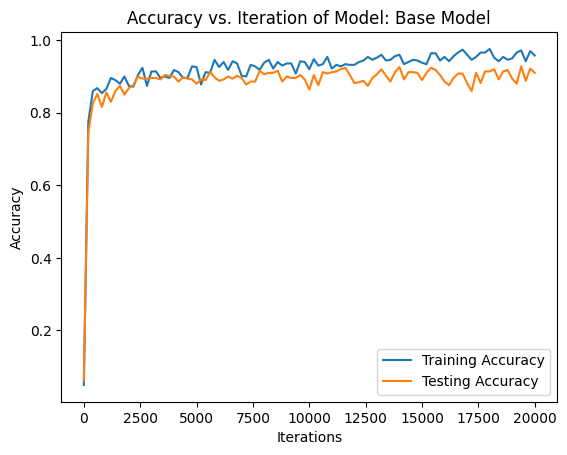

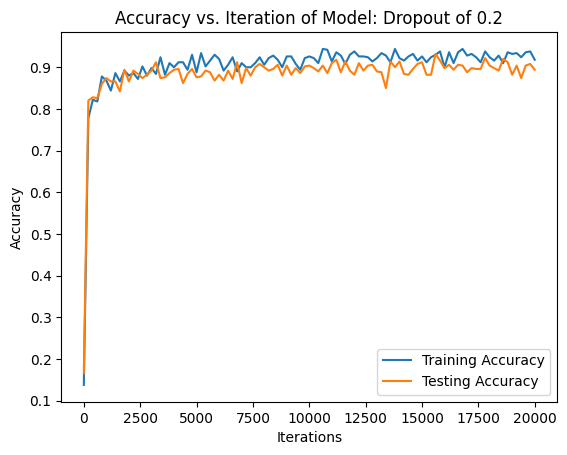

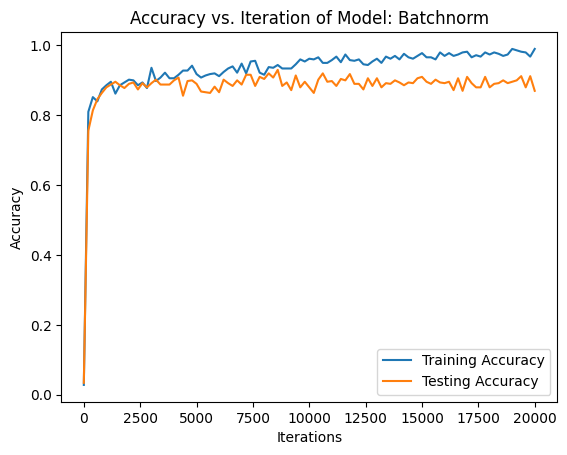

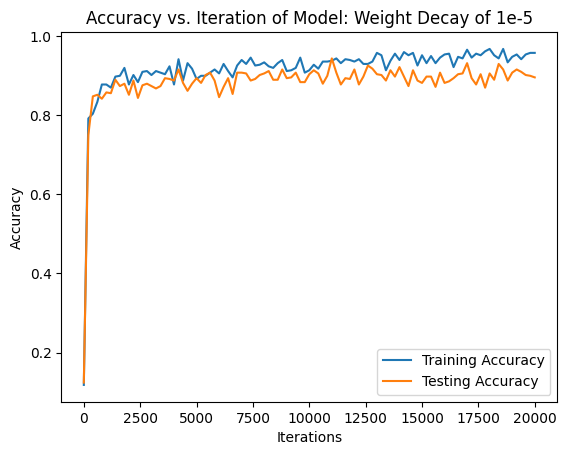

In [ ]:
# output and summary

# helper function to save gathered accuracies to a file
def saveaccuracies():
  file = open("accu.txt","w")
  file.write("y".join(["x".join([" ".join([f"{out[i][j][k]}" for k in range(101)]) for j in range(3)]) for i in range(4)]))
  file.close()

# helper function to load accuracies from a file
def loadaccuracies():
  file = open("accu.txt","r")
  s = file.read()
  file.close()
  return [[[float(el) for el in l.split(" ")] for l in p.split("x")] for p in s.split("y")]

#### use depening on what is needed:

#out = loadaccuracies()
saveaccuracies()

#### ------

# plotting
for i in range(4):
  plt.figure()
  plt.plot(out[i][2],out[i][0],label = "Training Accuracy")
  plt.plot(out[i][2],out[i][1],label = "Testing Accuracy")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs. Iteration of Model: " + modelnames[i])
  plt.legend(loc="lower right")

# printing summary
print("Summary:")
print(f"{'Model':<25}{'Train Accuracy (%)':<20}{'Test Accuracy (%)':<20}{'Best Iteration':<20}")
print("-"*80)

for i in range(4):
  def maxind(inlist):
    maxval = inlist[0]
    maxin = 0
    for j,val in enumerate(inlist[1:]):
      if val>maxval:
        maxin = j+1
        maxval = val
    return [maxin,maxval]

  maxtrain = maxind(out[i][0])
  maxtest = maxind(out[i][1])
  print(f"{modelnames[i]:<25}{out[i][0][maxtrain[0]]*100:<20.1f}{out[i][1][maxtest[0]]*100:<20.1f}{int(out[i][2][maxtest[0]]):<20}")

In [ ]:
#testing/inference

modelsix = Lenet5(0,False,1e-5).to(device)
modelsix.load_state_dict(torch.load("model3.pt", weights_only=True,map_location=torch.device('cpu')))

probe(modelsix)
print(list(enumerate(conversion)))

NameError: name 'Lenet5' is not defined